In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import batsim.transforms as batforms
import numpy as np
import galsim
import matplotlib.pyplot as plt
import fpfs

from batsim.stamp import Stamp
from astropy.io import fits

from PIL import Image, ImageOps

In [3]:
# Open an image file
image_path = "cat.png"
image = Image.open(image_path)
#image = image.transpose(3)
# Resize the image to fit within a 256x256 square while preserving aspect ratio
resized_image = image.resize((4*256, 4*256))

grayscale_image = resized_image.convert("L")

image_array = np.array(grayscale_image)

# Create a FITS HDU (Header Data Unit) from the NumPy array
fits_hdu = fits.PrimaryHDU(image_array)

fits_file_path = "cat_hires.fits"
fits_hdu.writeto(fits_file_path, overwrite=True)

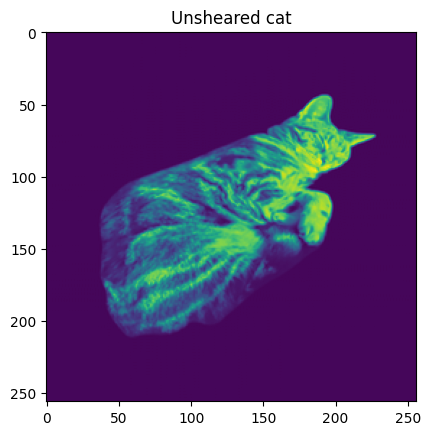

In [15]:
# Resize the image to fit within a 256x256 square while preserving aspect ratio
resized_image = image.resize((256, 256))

grayscale_image = resized_image.convert("L")

image_array = np.array(grayscale_image)

# Create a FITS HDU (Header Data Unit) from the NumPy array
fits_hdu = fits.PrimaryHDU(image_array)

# Write the FITS file
fits_file_path = "cat.fits"
fits_hdu.writeto(fits_file_path, overwrite=True)

cat_gal = galsim.InterpolatedImage("cat.fits", offset=[-20,40])
cat_noshear = cat_gal.drawImage(nx=256, ny=256, scale=1).array                    
plt.imshow(cat_noshear)
plt.title('Unsheared cat')
plt.savefig('cat_noshear')

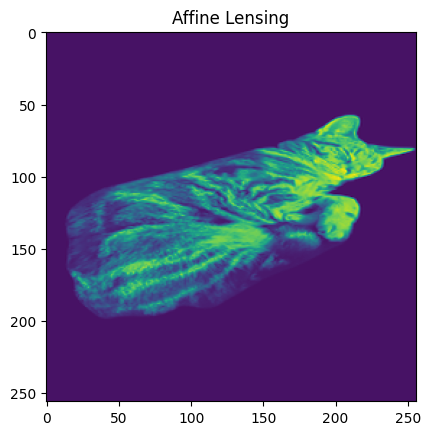

In [16]:
stamp = Stamp(nn=256, scale=1)
Lensing = batforms.LensTransform(gamma1=0.2, gamma2=0, kappa=0.01)
stamp.transform_grids(Lensing)

# get galaxy array from stamp object
cat_lensed = stamp.sample_galaxy(cat_gal)
plt.imshow(cat_lensed)
plt.title('Affine Lensing')
plt.savefig('lens_cat')

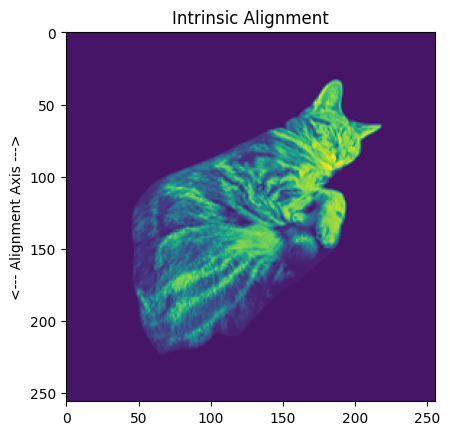

In [24]:
stamp = Stamp(nn=256, scale=1)
IA_cat = batforms.IaTransform(A=0.01, phi=np.radians(90), 
                              scale=1, hlr=2.5)
stamp.transform_grids(IA_cat)

# get galaxy array from stamp object
cat_IA = stamp.sample_galaxy(cat_gal)
plt.imshow(cat_IA)
plt.title('Intrinsic Alignment')
plt.ylabel('<--- Alignment Axis --->')
plt.savefig('IA_cat')

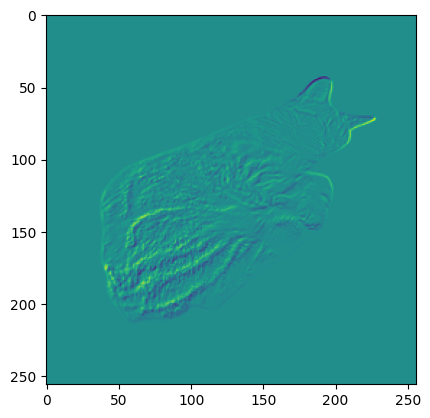

In [22]:
cat_residual = cat_noshear - cat_IA
plt.imshow(cat_residual)

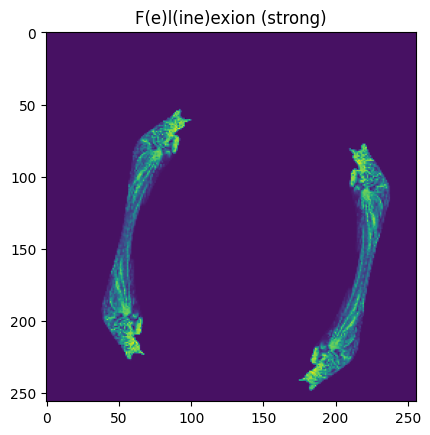

In [43]:
cat_gal = galsim.InterpolatedImage("cat.fits", offset=[150,150])
stamp = Stamp(nn=256, scale=1)
Felinexion = batforms.FlexionTransform(gamma1=0.0, gamma2=0.0, kappa=0,
                                      F1=0.015, F2=0.015, G1=0.02, G2=0.0)
stamp.transform_grids(Felinexion)

# get galaxy array from stamp object
cat_flex = stamp.sample_galaxy(cat_gal)
plt.imshow(cat_flex)
plt.title('F(e)l(ine)exion (strong)')
plt.savefig('flex_cat')

In [44]:
# define PSF
psf_array = np.zeros(stamp.shape)
psf_array[256 // 2, 256 // 2] = 1

coords = np.array([256//2, 256//2])
fpTask = fpfs.image.measure_source(psf_array, pix_scale=1, 
                                   sigma_arcsec=0.52)
mms = fpTask.measure(cat_lensed, coords)
mms = fpTask.get_results(mms)
ells= fpfs.catalog.fpfs_m2e(mms,const=20)
resp=np.average(ells['fpfs_R1E'])
shear=np.average(ells['fpfs_e1'])/resp
print("measured shear: %.6f" % shear)

2023/10/20 15:50:55 ---  Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/10/20 15:50:55 ---  Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023/10/20 15:50:55 ---  Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2023/10/20 15:50:55 ---  Order of the shear estimator: nnord=4
2023/10/20 15:50:55 ---  Shapelet kernel in configuration space: sigma= 0.5200 arcsec
2023/10/20 15:50:55 ---  Detection kernel in configuration space: sigma= 0.5200 arcsec
2023/10/20 15:50:55 ---  Maximum |k| is 3.117


measured shear: 0.367881


In [45]:
bias = abs(shear - 0.2)
print(bias)
print(bias/0.2)

0.16788100651928028
0.8394050325964014


In [46]:
from PIL import Image, ImageSequence

# List of image file paths to be included in the GIF
image_paths = ["cat_noshear.png", "lens_cat.png", 
               "IA_cat.png", "flex_cat.png"]  # Add more image paths as needed

# Open the images
images = [Image.open(path) for path in image_paths]

# Set duration (in milliseconds) for each frame in the GIF
frame_duration = 2000  # 100 milliseconds (0.1 seconds) per frame

# Create a list to store frames for the GIF
gif_frames = []

# Append images to the list of frames
for img in images:
    # Convert the image to "P" mode which uses a palette
    img = img.convert("P", palette=Image.ADAPTIVE)
    # Set the duration for this frame
    img.info["duration"] = frame_duration
    # Append the image to the list of frames
    gif_frames.append(img)

# Save the frames as a GIF
gif_frames[0].save("cat_shear.gif", save_all=True, append_images=gif_frames[1:], loop=0)


/tmp/ipykernel_87110/2428314930.py:19: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  img = img.convert("P", palette=Image.ADAPTIVE)
